In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from Losses import *
from Layers import *
from Datasets import *
from Metrics import *

import PyFireUpdate

import re
import librosa
from librosa.display import specshow
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
import numpy as np
import librosa
import glob
import re

def fix_length(signal, length=24414):
    signal_length = len(signal)
    if signal_length < length:
        tail_length = np.random.randint(low=0, high=length-signal_length)
        head_length = length - (signal_length + tail_length)

        signal = np.concatenate([np.zeros(head_length), signal, np.zeros(tail_length)]).astype('float32')
    else:
        signal = signal[:length]
    return signal

class MacaqueDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.files = sorted(glob.glob('Data/Macaque/*/*.wav'))
        self.audios = [fix_length(librosa.load(f, sr=None)[0]) for f in self.files]

        self.len = len(self.audios)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x = self.audios[idx]
        x = torch.tensor(x).unsqueeze(dim=0)
        return x, x

In [3]:
dataset = MacaqueDataset()
dataloader = DataLoader(dataset,
                        batch_size=8,
                        shuffle=True)
example = next(iter(dataloader))
example[0].size(), example[1].size()

(torch.Size([8, 1, 24414]), torch.Size([8, 1, 24414]))

In [4]:
from Encoders import HeavyEncoder
from Decoders import HeavyDecoder

In [26]:
class ConvAE(nn.Module):
    def __init__(self, encoder, decoder, return_z=False):
        super(ConvAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.return_z = return_z

    def forward(self, x):
        z = self.encoder(x)
        if self.return_z:
            return z
        else:
            x = self.decoder(z)
            #print(x.size())
            return x
a = torch.randn(7,1,24414)
#enc = Encoder()
#dec = ConvDecoder(enc)
#ae = ConvAE(enc, dec)
#print(ae(a).size())

In [27]:
sr=24414
encoder = HeavyEncoder(in_size=(None, 1, sr), nfft=int(25 / 1000 * sr), hop=int(10 / 1000 * sr))
decoder = HeavyDecoder(encoder)
ae = ConvAE(encoder, decoder)
ae(a).size()

torch.Size([7, 1, 24414])

In [28]:
model = ae
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = {'total_loss': lambda x, y: total_loss(x, y, STFT(1024, 1024//16, coords='polar', dB=False))}#{'stft_l1_loss': lambda x, y: raw2spec_mae_loss(x, y, STFT(1024, 1024//16, False))}
metric_func = {'si_sdr':si_sdr}
verbose = 2
device = 'cuda'
dest = None#'MacaqueAutoencoderV1'

Epoch: 4 
     >>>>> Train total_loss: 0.06622 
     >>>>> Val total_loss: 0.05649
     >>>>> Train si_sdr: -23.73657 --- Val si_sdr: -19.29724 
     >>>>> 55s: 16.56it/s


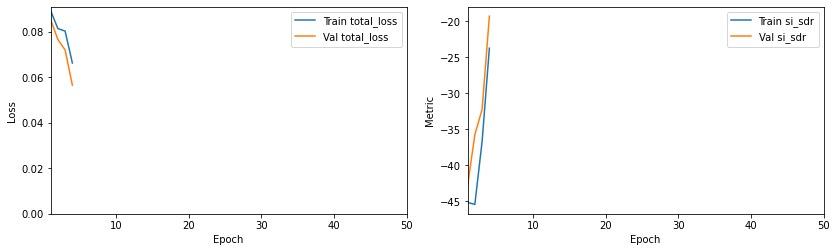

  5%|▌         | 50/911 [00:02<00:40, 21.02it/s]


KeyboardInterrupt: 

In [29]:
trainer = PyFireUpdate.Trainer(model, 
                         optimizer, 
                         loss_func=loss_func, 
                         metric_func=metric_func, 
                         verbose=verbose, 
                         device=device, 
                         dest=dest#,
                         #model_saver_callback={
                             #'epoch':25,
                             #'save_every':1
                         #}
                         )
trainer.fit(dataloader, dataloader, 50)

Epoch: 3 
     >>>>> Train total_loss: 0.03286 
     >>>>> Val total_loss: 0.02313
     >>>>> Train si_sdr: 0.71176 --- Val si_sdr: 4.58182 
     >>>>> 55s: 16.56it/s


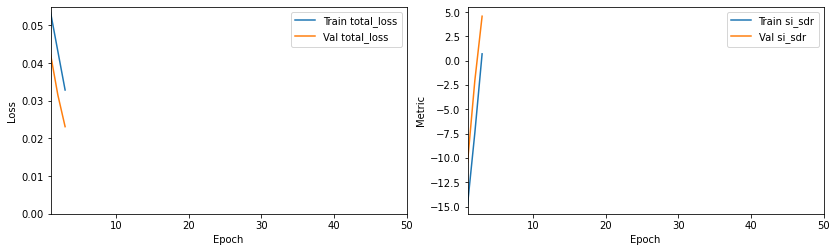

 33%|███▎      | 298/911 [00:13<00:28, 21.40it/s]


KeyboardInterrupt: 

In [30]:
from Autoencoder import Autoencoder as AE

ae = AE(encoder, decoder)
model = ae
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = {'total_loss': lambda x, y: total_loss(x, y, STFT(1024, 1024//16, coords='polar', dB=False))}#{'stft_l1_loss': lambda x, y: raw2spec_mae_loss(x, y, STFT(1024, 1024//16, False))}
metric_func = {'si_sdr':si_sdr}
verbose = 2
device = 'cuda'
dest = None#'MacaqueAutoencoderV1'
trainer = PyFireUpdate.Trainer(model, 
                         optimizer, 
                         loss_func=loss_func, 
                         metric_func=metric_func, 
                         verbose=verbose, 
                         device=device, 
                         dest=dest#,
                         #model_saver_callback={
                             #'epoch':25,
                             #'save_every':1
                         #}
                         )
trainer.fit(dataloader, dataloader, 50)